In [1]:
import gym
import random
import time
import numpy as np
import pandas as pd
from IPython.display import clear_output

from gym.envs.registration import register


# wrap in a try block to supress a warning we don't care about
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

## Intro to Q learning

#### Overview:

Before we created a random agent that can simulate continuous and discrete action spaces. Now we'll be looking at Frozen Lake. Slippery ice means actions don't always pan out (stochastic). We'll set `is_slippery` to `False` to make this a deterministic environment.

Change iteration loop to run while `done=False`.

Print updates at 0.5 second intervals.

Flush notebook output with `clear_output` command.

https://www.youtube.com/watch?v=wN3rxIKmMgE&list=PLIfPjWrv526bMF8_vx9BqWjec-F-g-lQO&index=3

In [2]:
#env_name = "CartPole-v1"
#env_name = "MountainCar-v0"
#env_name = "MountainCarContinuous-v0"
#env_name = "Acrobot-v1"
#env_name = "Pendulum-v0"
#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"   # we set is_slippery=False in the register up above

env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

type(env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


gym.spaces.discrete.Discrete

In [3]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
            
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                      self.action_high,
                                      self.action_shape)
        return action

To implement Q-learning, create Q-agent which a subclass of the parent agent.

Q table:
-States as rows
-Actions as columns

#### Redfine get-action method to select actions corresponding to the state. `argmax` is used to select the action with highest q-value.

#### Define a `train` method for updating the q-table at each step.

- It receives the `experience` tuple with `(state, action, next_state, reward, done)`.
- Calls for `q_next` (pulls next_state from q-table), and checks if this next_state is `done`.
- Calculates `q_target` from the Q-learning equation (reward plus _discounted_ future reward)
- Calculates `q_update`, which is the distance from the current q-value to the target.
- Pushes update to the q-table using _learning rate_.
- Constructor defines both the `discount_rate` and the `learning_rate` used above.

#### Balance exploration vs exploitation (aka policy or greedy action): epsilon (eps)
Start with high epsilon (aka 1.0 to explore 100% of the time), then exponentially decay eps at each terminal step

In [4]:
# QAgent is a subclass of the Agent class above

class QAgent(Agent):
    def __init__(self, env, discount_rate, learning_rate):
        super().__init__(env)
        
        # Action size already defined above in parent class
        
        # Define and printout state size here:
        self.state_size = env.observation_space.n
        print("State size", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        # build a Q table
        self.build_model()
        
    def build_model(self):
        np.random.seed(17)
        self.q_table = 1e-4*np.random.random([self.state_size, self.action_size])
        
    # modify get_action method
    def get_action(self, state):
        q_state = self.q_table[state]
        
        # exploration vs exploitation using probability of epsilon
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        
        # q table
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        
        q_update = q_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * q_update
        
        # Exponential decay of epsilon when reaching a terminal step
        if done:
            self.eps = self.eps * 0.99
        


### Adjusting the simulation loop for training

- env.step returns the next step, so make a variable called next_step
- call train method
- update the state to the next state
- train over a number of episodes
- and track the reward

In [5]:
def run(discount_rate, learning_rate):    
    agent = QAgent(env, discount_rate, learning_rate)
    total_reward = 0
    
    total_rewards = []
    for ep in range(100):
        state = env.reset()
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train((state,action,next_state,reward,done))
            state = next_state
            total_reward += reward

            print("s:", state, "a:", action)
            print("Episode: {}, Total Reward: {}, eps: {}".format(ep,total_reward,agent.eps))
            env.render()
            print(agent.q_table)
            time.sleep(0.5)
            clear_output(wait=True)
            
        total_rewards.append(total_reward)
    return total_rewards
        
            

In [6]:
run1 = run(0.97, 0.01)
run2 = run(0.97, 0.10)

s: 5 a: 0
Episode: 99, Total Reward: 26.0, eps: 0.36603234127322926
  (Left)
SFFF
FHFH
FFFH
HFFG
[[8.32972005e-01 8.57811511e-01 8.58734026e-01 8.32972005e-01]
 [8.32972005e-01 6.56333522e-47 8.85292810e-01 8.58733998e-01]
 [8.58734026e-01 9.12673000e-01 8.58734026e-01 8.85292810e-01]
 [8.85292810e-01 8.77290526e-19 8.36910094e-05 8.58648160e-01]
 [7.60210171e-05 8.85288358e-01 4.83528624e-25 7.57684887e-05]
 [2.97725718e-05 5.61508905e-05 3.96047436e-05 7.88700710e-05]
 [4.18484385e-19 9.40900000e-01 1.50906694e-17 8.85292801e-01]
 [7.18037194e-05 2.92317355e-05 1.98773872e-05 8.31363922e-05]
 [8.76091043e-01 8.23397492e-20 9.12672918e-01 7.83239714e-05]
 [8.76091067e-01 9.31306495e-01 9.40900000e-01 8.87982434e-13]
 [9.12672954e-01 9.70000000e-01 9.60787756e-27 9.12673000e-01]
 [7.18776083e-05 7.43576765e-05 8.87736352e-05 1.33945668e-05]
 [7.76974581e-05 8.37991512e-05 8.29304764e-05 2.91569965e-06]
 [3.90374491e-07 9.40804042e-01 9.69998070e-01 9.03547156e-01]
 [9.40618704e-01 9.69

In [14]:
run3 = run(0.97, 1.0)

s: 7 a: 1
Episode: 99, Total Reward: 29.0, eps: 0.36603234127322926
  (Down)
SFFF
FHFH
FFFH
HFFG
[[8.32972005e-01 8.07982845e-01 8.58734026e-01 8.32972005e-01]
 [8.32972005e-01 0.00000000e+00 8.85292810e-01 8.58734026e-01]
 [8.58734026e-01 9.12673000e-01 8.58734026e-01 8.85292810e-01]
 [8.85292810e-01 0.00000000e+00 5.11936656e-06 6.52418615e-05]
 [8.10437592e-05 6.36765729e-05 0.00000000e+00 8.32972005e-01]
 [2.97725718e-05 5.61508905e-05 3.96047436e-05 7.88700710e-05]
 [0.00000000e+00 9.40900000e-01 0.00000000e+00 8.85292810e-01]
 [7.18037194e-05 2.92317355e-05 1.98773872e-05 8.31363922e-05]
 [5.34422845e-05 0.00000000e+00 9.12673000e-01 5.19142863e-05]
 [8.85292810e-01 9.40900000e-01 9.40900000e-01 0.00000000e+00]
 [9.12673000e-01 9.70000000e-01 0.00000000e+00 9.12673000e-01]
 [7.18776083e-05 7.43576765e-05 8.87736352e-05 1.33945668e-05]
 [7.76974581e-05 8.37991512e-05 8.29304764e-05 2.91569965e-06]
 [0.00000000e+00 9.40900000e-01 9.70000000e-01 9.12673000e-01]
 [9.40900000e-01 9.70

In [15]:
run4 = run(0.97, 10.0)

s: 5 a: 2
Episode: 99, Total Reward: 2.0, eps: 0.36603234127322926
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 3.55297615e+245  3.78006219e+247 -2.18130009e+244  3.55319926e+245]
 [ 1.00449035e+247  6.46338154e+016 -1.21328156e+214  5.09082392e+216]
 [ 1.82048629e+235 -1.67498244e+168  6.96604258e+167  5.86619715e+184]
 [ 7.18148720e+166 -5.18031283e+000  1.08849795e+128  5.17363077e+128]
 [ 4.52240002e+242  3.51790344e+214  1.34483038e+028  4.30969431e+246]
 [ 2.97725718e-005  5.61508905e-005  3.96047436e-005  7.88700710e-005]
 [ 2.22399760e+001 -5.33355372e+032  8.01980046e+000  1.51660195e+213]
 [ 7.18037194e-005  2.92317355e-005  1.98773872e-005  8.31363922e-005]
 [ 4.81452753e+129  2.32551772e+006 -2.11032189e+134 -1.19744813e+205]
 [-4.09375561e+127  9.43079329e+002 -1.42984653e+021  4.71910273e+001]
 [-1.34105435e+020 -4.19922231e+001  6.30372847e-001 -7.03273161e+031]
 [ 7.18776083e-005  7.43576765e-005  8.87736352e-005  1.33945668e-005]
 [ 7.76974581e-005  8.37991512e-005  8.29304764e-00

In [16]:
run1[-1]

5.0

In [17]:
run2[-1]

11.0

In [18]:
run3[-1]

29.0

In [20]:
run4[-1]

2.0

In [21]:
from matplotlib import pyplot as plt

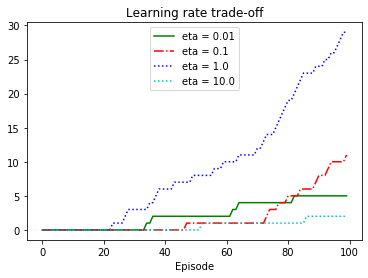

In [22]:
episodes = [ep for ep in range(100)]

plt.plot(episodes, run1, 'g-', label='eta = 0.01')   # green solid line
plt.plot(episodes, run2, 'r-.', label='eta = 0.1') # red dot-dashed line
plt.plot(episodes, run3, 'b:', label='eta = 1.0') # blue dotted line
plt.plot(episodes, run4, 'c:', label='eta = 10.0') # blue dotted line


plt.legend(loc=9) # loc=9 means "top center"
plt.xlabel("Episode")
plt.title("Learning rate trade-off")
plt.show()